# House prices

## Data Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# display number with two digits
pd.options.display.float_format = '{:.2f}'.format 

# color code for graph
sns.set(style="ticks", color_codes=True, palette='Set3')

#Print color configuration 
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Read data
data = pd.read_csv( 'house-prices.csv')
print('Original data shape = {}'.format( data.shape))

# Remove Order and PID columns: not usefull
def drop_col_notUsefull( data):
    columns_droped_not_usefull = ['Order','PID']
    data.drop( columns_droped_not_usefull, axis=1, inplace=True)
    
drop_col_notUsefull( data)

Original data shape = (2430, 82)


## Data type conversion

In [2]:
# convert date columns into datetime type
def convert_dateTime_col( data):
    date_columns = ['Year Built','Year Remod/Add','Garage Yr Blt','Yr Sold']

    for col in date_columns:
        data[ col] =  pd.to_datetime( data[col], format='%Y')

convert_dateTime_col( data)

## Data description

I check number of value for each numeric columns

In [3]:
print('Number of numeric columns= {}'.format( data.select_dtypes( np.number).columns.size))

display( data.iloc[:, 0:14].describe())
display( data.iloc[:, 14:28].describe())
data.iloc[:, 28:37].describe()

Number of numeric columns= 33


,MS SubClass,Lot Frontage,Lot Area
count,2430.00,2010.00,2430.00
mean,57.09,69.20,10243.56
std,42.90,23.49,8353.93
min,20.00,21.00,1470.00
25%,20.00,58.00,7482.00
50%,50.00,68.00,9500.00
75%,70.00,80.00,11604.50
max,190.00,313.00,215245.00


,Overall Qual,Overall Cond,Mas Vnr Area
count,2430.00,2430.00,2410.00
mean,6.09,5.57,102.00
std,1.41,1.12,176.61
min,1.00,1.00,0.00
25%,5.00,5.00,0.00
50%,6.00,5.00,0.00
75%,7.00,6.00,164.75
max,10.00,9.00,1600.00


,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF
count,2429.00,2429.00,2429.00
mean,443.94,51.07,556.48
std,457.45,172.14,439.65
min,0.00,0.00,0.00
25%,0.00,0.00,216.00
50%,375.00,0.00,462.00
75%,737.00,0.00,799.00
max,5644.00,1526.00,2336.00


## Too many missing values

Remove columns with too many Nan, because these columns give too little information and I do not have information to estimate another value to fill in.

In [4]:
# get the list of columns with less than 2000 value out of 2430, 
column_with_Nan = data.count() < 2000

# get the columns name
columns_droped_nan = column_with_Nan[ column_with_Nan == True].index

#get the column and number of NaN
print( color.PURPLE + 'Columns droped because they have less than 2000 values' + color.END)
display( data.count()[ columns_droped_nan])

#remove those five columns
def drop_tooManyMissingValues_col( data, columns_droped_nan):
    data.drop( columns_droped_nan, inplace=True, axis=1)
    
#My method is better replace by dropna  
#drop_tooManyMissingValues_col( data, columns_droped_nan)
data.dropna(axis=1, thresh=2000, inplace=True)

Columns droped because they have less than 2000 values


Alley            163
Fireplace Qu    1244
Pool QC           12
Fence            489
Misc Feature      90
dtype: int64

## Fill in missing value

In [5]:
# Display NaN counts for each columns
s = pd.Series()

print( color.PURPLE + 'Columns with NaN:' + color.END)
for col in data.columns:
    #get Nan counts
    Nan_count = data[ col].isnull().sum()
    if (Nan_count != 0):
        #append Nan count to the serie
        s = s.append( pd.Series( Nan_count, index=[ col]))

# sort serie and print       
s.sort_values( ascending=False, inplace=True)
print( s)

# Can be done in one line, but display festures with zero NaN
# print( data.isna().sum().sort_values(ascending=False) )

Columns with NaN:
Lot Frontage      420
Garage Finish     138
Garage Qual       138
Garage Yr Blt     138
Garage Cond       138
Garage Type       136
Bsmt Exposure      74
BsmtFin Type 2     72
BsmtFin Type 1     71
Bsmt Qual          71
Bsmt Cond          71
Mas Vnr Type       20
Mas Vnr Area       20
Bsmt Half Bath      2
Bsmt Full Bath      2
Garage Cars         1
BsmtFin SF 1        1
BsmtFin SF 2        1
Garage Area         1
Total Bsmt SF       1
Electrical          1
Bsmt Unf SF         1
dtype: int64


In [6]:
def replace_nan( data):
    # Replace NaN by 0 in four continuous Basement columns because 'Total Bsmt SF' == NaN
    basement_continuous = ['BsmtFin SF 1','BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']
    data.loc[ data['Total Bsmt SF'].isnull(), basement_continuous] = 0

    # Replace NaN by NA in five categorical Basement columns because 'Total Bsmt SF' == 0
    basement_categorial = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']
    data.loc[ data['Total Bsmt SF'] == 0,  basement_categorial] = 'NA'

    # Replace NaN by No in 'Bsmt Exposure' because 'Total Bsmt SF' != 0
    condition1 = data['Bsmt Exposure'].isnull()
    condition2 = data['Total Bsmt SF'] != 0
    data.loc[ condition1 & condition2, 'Bsmt Exposure'] = 'No'

    # Replace NaN by ALQ in 'BsmtFin Type 2' column, because 'Bsmt Cond' == 'TA'
    condition1 = data['BsmtFin Type 2'].isnull()
    condition2 = data['Bsmt Cond'] == 'TA'
    data.loc[ condition1 & condition2,  'BsmtFin Type 2'] = 'ALQ'

    # Replace NaN by 0 in 'Bsmt Full Bath' column, because 'Total Bsmt SF' == 0
    condition1 = data['Bsmt Full Bath'].isnull()
    condition2 = data['Total Bsmt SF'] == 0
    data.loc[ condition1 & condition2,  'Bsmt Full Bath'] = 0

    # Replace NaN by 0 in 'Bsmt Half Bath' column, because Total Bsmt SF' == 0
    condition1 = data['Bsmt Half Bath'].isnull()
    condition2 = data['Total Bsmt SF'] == 0
    data.loc[ condition1 & condition2,  'Bsmt Half Bath'] = 0
    
replace_nan( data)

The distribution of points is similar between Lot Frontage and Lot Area. As Lot Area has no missing value nor zero value, I will use it to sort houses and then fill in missing value of Lot Frontage with interpolation.


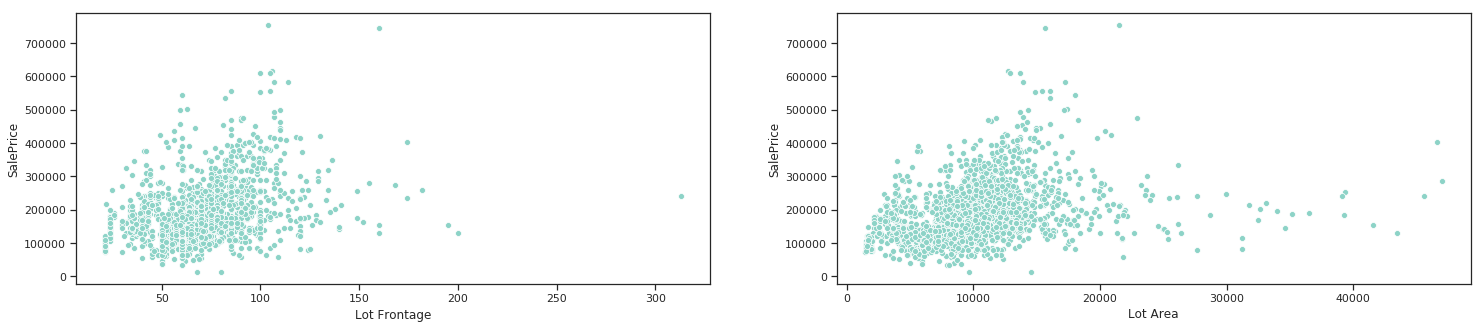

In [7]:
# Replace NaN in 'Lot Frontage'
columns_selection = ['Lot Frontage','Lot Area','SalePrice']

# Remove some extreme values in 'Lot Area' column in order to have a display similar to 'Lot Frontage' column.
data2 = data.loc[ data['Lot Area'] < 50000,  columns_selection ]

f, axes = plt.subplots(1, 2, figsize=(25, 5), sharey=False)

print('The distribution of points is similar between Lot Frontage and Lot Area. As Lot Area has no missing value nor zero value, I will use it to sort houses and then fill in missing value \
of Lot Frontage with interpolation.')

# display plots
columns_selection.remove( 'SalePrice')
for idx, col in enumerate( columns_selection):
    ax = sns.scatterplot(x=data2[ col], y=data2['SalePrice'], ax=axes[ idx % 2])
    ax.set_xlabel( col)
 
def replace_nan_lotArea( data):
    #sort by Lot Area, because it has no Nan nor zero value, so all rows are sorted.
    data.sort_values( by='Lot Area', inplace=True)

    # Interpolate and forward/backward fill in case first_last row is NaN
    data['Lot Frontage'] = data['Lot Frontage'].interpolate( method='linear').fillna( method='ffill').fillna( method='bfill')

replace_nan_lotArea( data)

In [8]:
# Replace NaN in garage columns
garage_columns = ['Garage Area','Garage Type','Garage Yr Blt', 'Garage Finish','Garage Cars']

# get rows with at least one NaN in garage columns 
mask = data[ garage_columns].isnull().any( axis='columns')

print('Garage columns have 138 missing values at the same rows.\n')
display( data.loc[ mask, garage_columns ].head() )

def replace_nan_garage( data):
    # Replace NaN by NA in categorial Garage columns
    values = {'Garage Cond': 'NA', 'Garage Qual': 'NA', 'Garage Finish': 'NA', 'Garage Type': 'NA'}
    data.fillna( value=values, inplace=True)

    # Replace NaN in 'Garage year built' with date from 'Year Built'
    data['Garage Yr Blt'].fillna( data['Year Built'], inplace=True )

    # Replace NaN in 'Garage Cars' and 'Garage Area' with interpolation. Sort by 'Total Bsmt SF', because it has no NaN. 
    data.sort_values( by='Total Bsmt SF', inplace=True)

    # Interpolate and forward/backward fill in case first_last row is NaN
    data['Garage Area'] = data['Garage Area'].interpolate( method='linear').fillna( method='ffill').fillna( method='bfill')
    data['Garage Cars'] = data['Garage Cars'].interpolate( method='linear').fillna( method='ffill').fillna( method='bfill')
    
replace_nan_garage( data)

Garage columns have 138 missing values at the same rows.



,Garage Area,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars
458,0.00,NaN,NaT,NaN,0.00
2133,0.00,NaN,NaT,NaN,0.00
687,0.00,NaN,NaT,NaN,0.00
191,0.00,NaN,NaT,NaN,0.00
1629,0.00,NaN,NaT,NaN,0.00


In [9]:
# Replace NaN by None in 'Mas Vnr Type' and NaN by 0 in 'Mas Vnr Area', because there is no Masonry.
def replace_nan_electrical( data):
    condition1 = data['Mas Vnr Type'].isnull()
    condition2 = data['Mas Vnr Area'].isnull()
    data.loc[ condition1 & condition2,  ['Mas Vnr Type', 'Mas Vnr Area']] = ['None', 0]

    # Replace NaN by No in 'Bsmt Exposure' column, because
    data.loc[ data['Bsmt Exposure'].isnull(),  'Bsmt Exposure'] = 'No'

    # Replace NaN is 'Electrical' based on value in 'Overall Cond'
    def replaceValue( x,y):
        if pd.isna( x):
            if y in range(7,11):
                return 'SBrkr'
            elif y in range( 5,7):
                return 'FuseA'
            elif y in range( 3,5):
                return 'FuseF'
            elif y in range( 1,3):
                return 'FuseP'
        else:
            return x

    data['Electrical'] = data.apply( lambda row: replaceValue( row['Electrical'], row['Overall Cond']), axis=1)
    
replace_nan_electrical( data)

## Not enough information: One value with a high frequency

Remove Columns with mainly one single value because it gives too few information and it can leads to overfitting.

In [10]:
# list of Categorical (Nominal and Ordinal) columns
categorical_columns = ['MS SubClass','MS Zoning','Street','Lot Shape','Land Contour','Utilities','Lot Config','Land Slope',
                      'Neighborhood','Condition 1', 'Condition 2', 'Bldg Type', 'House Style','Overall Qual','Overall Cond',
                      'Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Exter Qual','Exter Cond','Foundation',
                      'Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating','Heating QC',
                      'Central Air','Electrical','Kitchen Qual','Functional','Garage Type','Garage Finish',
                     'Garage Qual','Garage Cond','Paved Drive','Sale Type','Sale Condition']

discrete_columns = ['Year Built','Year Remod/Add','Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces',
                   'Garage Yr Blt','Garage Cars','Mo Sold','Yr Sold']

continuous_columns = ['Lot Frontage','Lot Area','Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area',
                     'Garage Area','Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area','Misc Val']

# Print in a file, value frequency for each categorical and discrete column.
file_name = 'columns value frequency (categorical and discrete).txt'
with open( file_name, 'w') as f:   
    for col in (categorical_columns + discrete_columns):
        x = data[ col].value_counts(dropna=False, normalize=True)
        print('Column \'{}\', values are:\n{}'.format(col,x), file=f)
        print(file=f)

print( 'Values frequency for each categorical and discrete features are printed in file \'{}\'\n'.format( file_name))
      
# Columns with mainly one single value (frequency >= 0.85)
columns_droped_one_single_value = ['Street', 'Utilities', 'Condition 2','Roof Matl', 'Exter Cond', 'Bsmt Cond','BsmtFin Type 2','Heating','Central Air', 'Electrical', 'Functional', \
                            'Garage Qual', 'Garage Cond', 'Paved Drive', 'Sale Type','Bsmt Half Bath','Kitchen AbvGr']
print( color.PURPLE + 'Columns droped because they have mainly one single value (frequency >= 0.85) , that can lead to overfitting:\n' + color.END + '{}'.format( columns_droped_one_single_value))

#remove those columns
def drop_oneSingleValue_col( data):
    data.drop( columns_droped_one_single_value, inplace=True, axis=1)
    
drop_oneSingleValue_col( data)

# Remove droped columns from columns list
categorical_columns = list( set(categorical_columns).difference( set(columns_droped_one_single_value) ))
discrete_columns= list( set(discrete_columns).difference( set(columns_droped_one_single_value) ))
continuous_columns = list( set(continuous_columns).difference( set(columns_droped_one_single_value) ))

Values frequency for each categorical and discrete features are printed in file 'columns value frequency (categorical and discrete).txt'

Columns droped because they have mainly one single value (frequency >= 0.85) , that can lead to overfitting:
['Street', 'Utilities', 'Condition 2', 'Roof Matl', 'Exter Cond', 'Bsmt Cond', 'BsmtFin Type 2', 'Heating', 'Central Air', 'Electrical', 'Functional', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Sale Type', 'Bsmt Half Bath', 'Kitchen AbvGr']


## Duplicate

Remove duplicated rows

In [11]:
# get the number of duplicate in data
duplicate_count = data.duplicated().sum()
print('There is {} duplicate row, I remove it.'.format( duplicate_count) )

# get index of duplicate
duplicate_idx = data[ data.duplicated() ].index

# remove duplicate from data
data.drop( duplicate_idx, inplace= True)

There is 1 duplicate row, I remove it.


## Outliers

Remove outliers

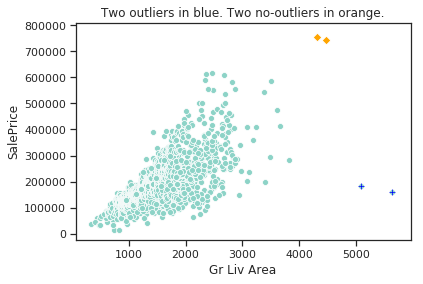

I decide to keep the two orange points with SalePrice > 700000, because they are following the trend.

I decide to remove the two points in blue with 'Gr Liv Area' > 5000, because they are out of the trend.


In [12]:
# display data for 'Gr Liv Area'
sns.scatterplot(x=data['Gr Liv Area'], y=data['SalePrice'])

# Select outliers: Gr Liv Area > 5000
outlier_idx = data.loc[ data['Gr Liv Area'] > 5000 ].index

# show outliers
data_outlier = data.loc[ outlier_idx]
sns.scatterplot(x=data_outlier['Gr Liv Area'], y=data_outlier['SalePrice'], marker='+', color='blue')

# Show non Outliers: SalePrice > 700000
non_outlier_idx = data.loc[ data['SalePrice'] > 700000 ].index
data3 = data.loc[ non_outlier_idx]

# Plot
ax = sns.scatterplot(x=data3['Gr Liv Area'], y=data3['SalePrice'], marker='D', color='orange')
ax.set_title('Two outliers in blue. Two no-outliers in orange.')
plt.show()

print('I decide to keep the two orange points with SalePrice > 700000, because they are following the trend.\n')
print('I decide to remove the two points in blue with \'Gr Liv Area\' > 5000, because they are out of the trend.')

# I remove these two outliers because they are partial sales whose price is far away from other values. 
data.drop( outlier_idx, inplace=True)


### Discrete features

Check values of discrete features are in valid range

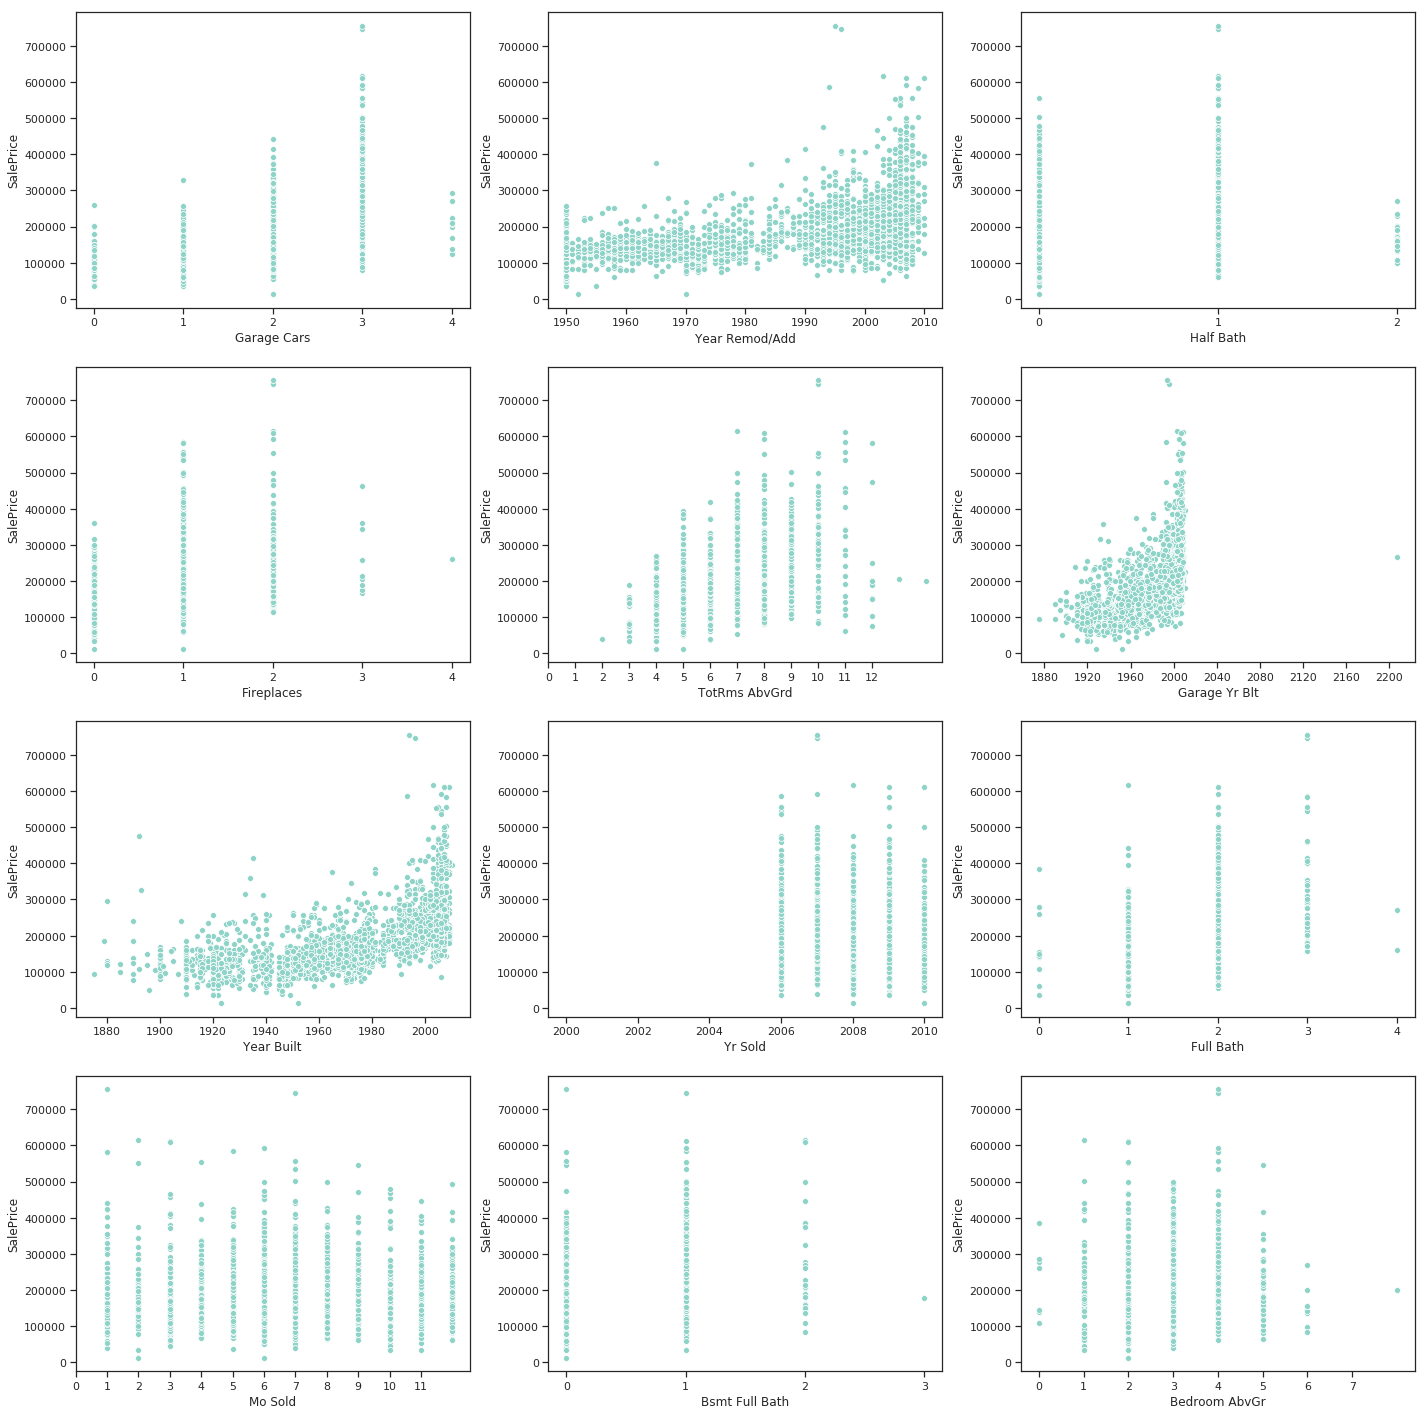

In [13]:
# display plots
f, axes = plt.subplots(4, 3, figsize=(24, 25), sharey=False)

# show plot for all discrete columns
for idx, col in enumerate(discrete_columns):
    ax = sns.scatterplot(x=data[ col], y=data['SalePrice'], ax=axes[ (idx // 3), (idx % 3)])
    #set x ticks for columns not containing Year.
    if not any(st in col for st in ['Year', 'Yr'] ):
        ax.set_xticks( np.arange( len( data[ col].unique()) ));
    ax.set_xlabel( col)


In [14]:
# Change wrong values

print( color.PURPLE + 'There is one false data in \'garage year built\', I replace 2207 by 2007.\n' + color.END)
display( data.loc[ (data['Garage Yr Blt'] > pd.Timestamp(2200, 1, 1)), ['Year Built','Year Remod/Add','Garage Yr Blt']] )

#I set the year = 2007
data.loc[ (data['Garage Yr Blt'] > pd.Timestamp(2200, 1, 1)), ['Garage Yr Blt']] = pd.Timestamp(2007, 1, 1)
      

There is one false data in 'garage year built', I replace 2207 by 2007.



,Year Built,Year Remod/Add,Garage Yr Blt
2219,2006-01-01,2007-01-01,2207-01-01


### Continuous features

Check values of continuous columns are in valid range

In 'Lot Area' there are 4 values > 100 000 square feet, they look like outliers but I don't find any explanation in the others columns, so I decide to keep them.

In 'Total Bsmt SF' there are many 0 values, but they are not missing values because: 1. 'BsmtFin SF 1' and 'Bsmt Unf SF' are also equal to 0, that is consistent. 2. 'Gr Liv Area' and '1st Fl SF' are not equal to 0.

In 'Wood Deck SF', 'Open Porch SF' and 'Enclosed Porch', three values look like outliers but I don't find any explanation, so I decide to keep them.


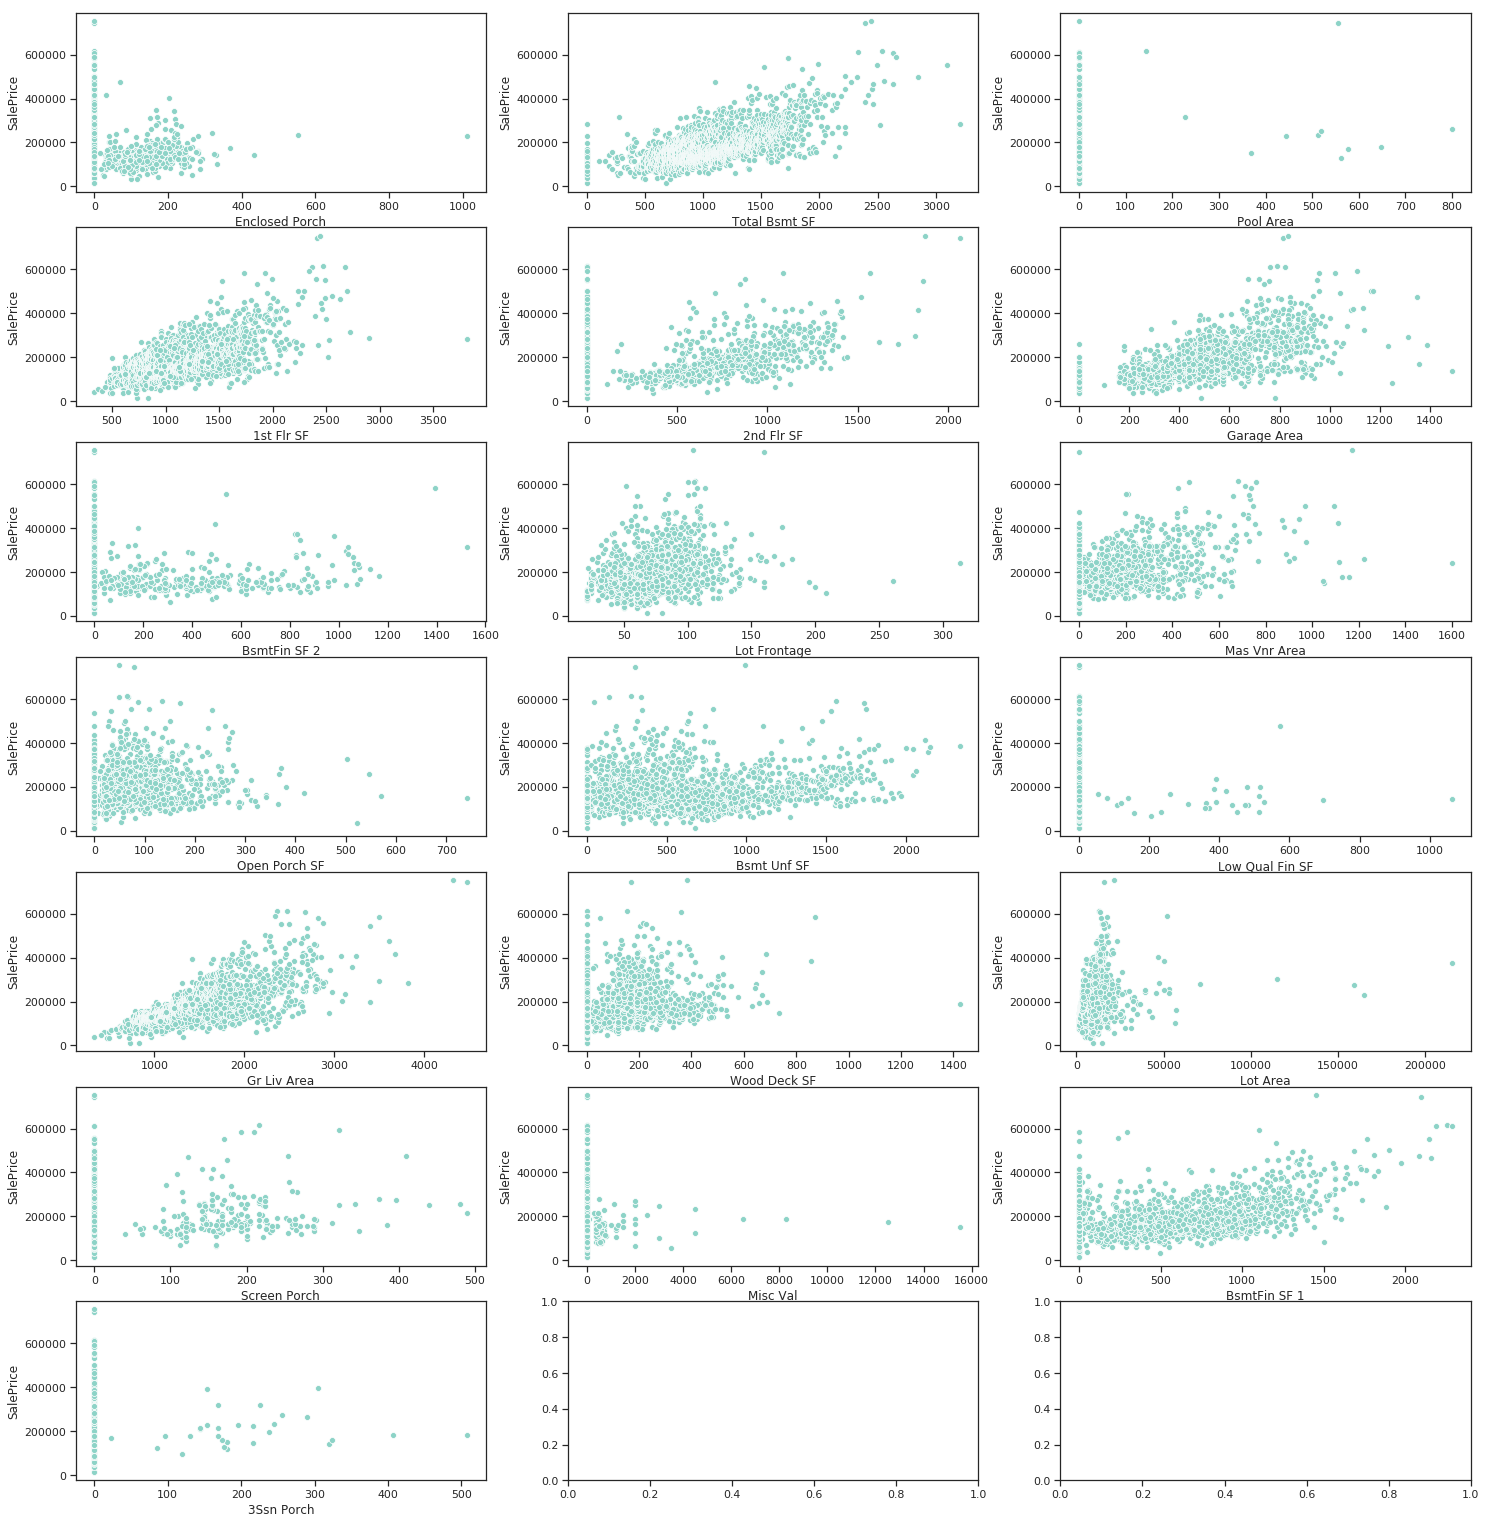

In [15]:
# display graphs
f, axes = plt.subplots(7, 3, figsize=(25, 27), sharey=False)

# Plot
for idx, col in enumerate(continuous_columns):
    ax = sns.scatterplot(x=data[ col], y=data['SalePrice'], ax=axes[ (idx // 3), (idx % 3)])
    ax.set_xlabel( col)
    
print('In \'Lot Area\' there are 4 values > 100 000 square feet, they look like outliers but I don\'t find any explanation in the others columns, so I decide to keep them.\n')
print('In \'Total Bsmt SF\' there are many 0 values, but they are not missing values because: 1. \'BsmtFin SF 1\' and \'Bsmt Unf SF\' are also equal to 0, that is consistent. 2. \'Gr Liv Area\' and \'1st Fl SF\' are not equal to 0.\n')
print('In \'Wood Deck SF\', \'Open Porch SF\' and \'Enclosed Porch\', three values look like outliers but I don\'t find any explanation, so I decide to keep them.' )



In [16]:
# Remove columns that have too many zero values, because they don't give any information and can lead to overfitting.
s = pd.Series()

#compute the percentage of zero values for each continuous column
for col in continuous_columns:
    zero_count = data[ col].isin( [0]).sum()
    total_count = data[ col].shape[0]
    zero_percentage = round( zero_count / total_count, 3)
    s = s.append( pd.Series( zero_percentage, index=[ col]) )

# sort serie and print       
s.sort_values( ascending=False, inplace=True)
print( color.PURPLE + 'Percentage of zero values in continuous columns:\n' + color.END + '{}\n'.format( s))

columns_droped_many_zero = ['Pool Area','Low Qual Fin SF', '3Ssn Porch', 'Misc Val', 'Screen Porch', 'BsmtFin SF 2', 'Enclosed Porch']
print( color.PURPLE + 'I decide to drop columns with more than 60% of zero values:\n'+ color.END + '{}'.format( columns_droped_many_zero))

# drop columns
def drop_manyZero( data):
    data.drop( columns_droped_many_zero, axis=1, inplace=True)

drop_manyZero( data)
    
# Remove droped columns from columns list
continuous_columns = list( set(continuous_columns).difference( set(columns_droped_many_zero) ))

Percentage of zero values in continuous columns:
Pool Area         0.99
3Ssn Porch        0.99
Low Qual Fin SF   0.99
Misc Val          0.96
Screen Porch      0.91
BsmtFin SF 2      0.88
Enclosed Porch    0.84
Mas Vnr Area      0.60
2nd Flr SF        0.58
Wood Deck SF      0.52
Open Porch SF     0.45
BsmtFin SF 1      0.32
Bsmt Unf SF       0.09
Garage Area       0.06
Total Bsmt SF     0.03
Gr Liv Area       0.00
Lot Frontage      0.00
1st Flr SF        0.00
Lot Area          0.00
dtype: float64

I decide to drop columns with more than 60% of zero values:
['Pool Area', 'Low Qual Fin SF', '3Ssn Porch', 'Misc Val', 'Screen Porch', 'BsmtFin SF 2', 'Enclosed Porch']


### Categorical features

Check values of categorical features are in valid range

To keep in mind, Columns with a value that has zero count:
Bsmt Cond 		 NA
Bsmt Exposure 		 NA
Bsmt Qual 		 NA
BsmtFin Type 1 		 NA
BsmtFin Type 2 		 NA
Exter Qual 		 Po
Fence 		 NA
Fireplace Qu 		 NA
Garage Cond 		 NA
Garage Finish 		 NA
Garage Qual 		 NA
Garage Type 		 NA
MS Zoning 		 RP
Overall Cond 		 10
Pool QC 		 NA
Roof Matl 		 roll


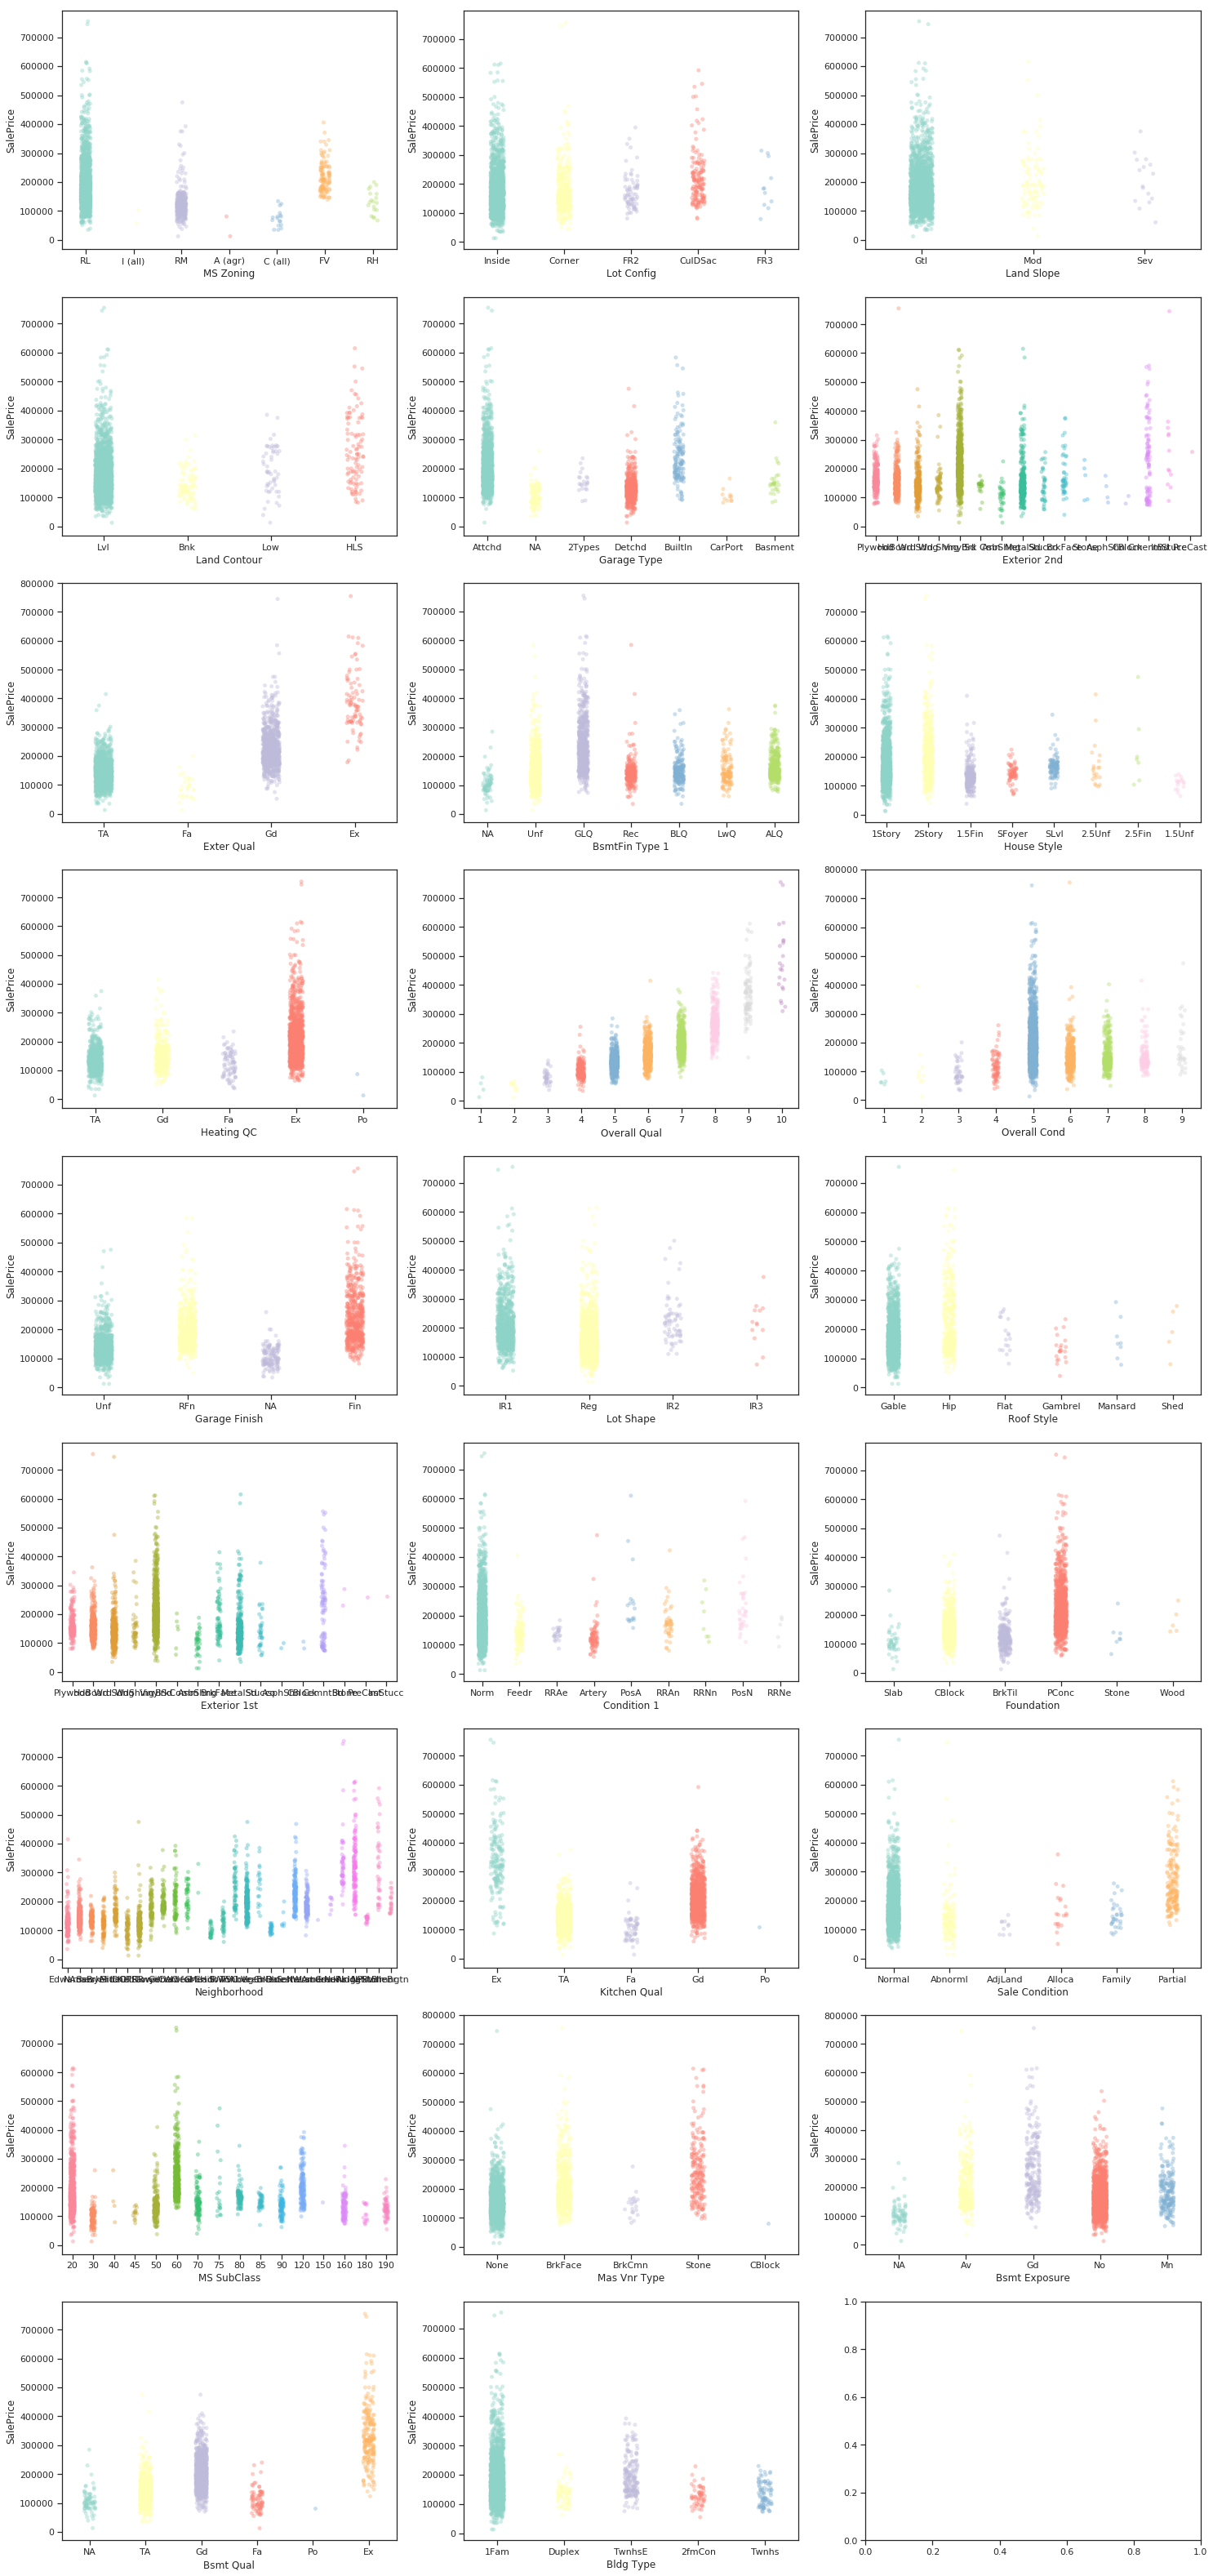

In [17]:
# display plots
f, axes = plt.subplots(9, 3, figsize=(25, 57), sharey=False)

# Plot
for idx, col in enumerate(categorical_columns):
    i= idx // 3
    j= idx % 3
    ax = sns.stripplot(x=col, y="SalePrice", data=data, jitter=True, alpha=.4, ax=axes[ i, j] )
    ax.set_xlabel( col)
    
# Missing value in column 
column_missing_value = {'MS Zoning':'RP', 'Overall Cond':10, 'Roof Matl':'roll', 'Exter Qual':'Po', 'Bsmt Qual':'NA', 'Bsmt Cond':'NA', 'Bsmt Exposure':'NA', 'BsmtFin Type 1':'NA',
                        'BsmtFin Type 2':'NA', 'Fireplace Qu':'NA', 'Garage Type':'NA', 'Garage Finish':'NA', 'Garage Qual':'NA', 'Garage Cond':'NA', 'Pool QC':'NA', 'Fence': 'NA'}
print( color.PURPLE + 'To keep in mind, Columns with a value that has zero count:' + color.END )

for key, value in sorted( column_missing_value.items() ):
    print( key, '\t\t', value)

## Outlier detection

Some continuous features show some points far away from the rest of the point population, so they may be outliers. I use the InterQuantile Range (IQR) method to show potential outliers. I separate data into two sub-population with and without zero. Then I detect potential outliers with the IQR method on sub-population without zero. I use differnet coefficient in IQR method depending on which point are selected for each feature.

0 	outliers in	Total Bsmt SF  	without zero values. IQR coeff = 4.5
1 	outliers in	1st Flr SF  	without zero values. IQR coeff = 3.5
1 	outliers in	2nd Flr SF  	without zero values. IQR coeff = 3.5
0 	outliers in	Garage Area  	without zero values. IQR coeff = 4.5
2 	outliers in	Lot Frontage  	without zero values. IQR coeff = 6
1 	outliers in	Mas Vnr Area  	without zero values. IQR coeff = 5
5 	outliers in	Open Porch SF  	without zero values. IQR coeff = 4.5
0 	outliers in	Bsmt Unf SF  	without zero values. IQR coeff = 3.5
2 	outliers in	Gr Liv Area  	without zero values. IQR coeff = 3.5
1 	outliers in	Wood Deck SF  	without zero values. IQR coeff = 6
4 	outliers in	Lot Area  	without zero values. IQR coeff = 15
0 	outliers in	BsmtFin SF 1  	without zero values. IQR coeff = 3.5


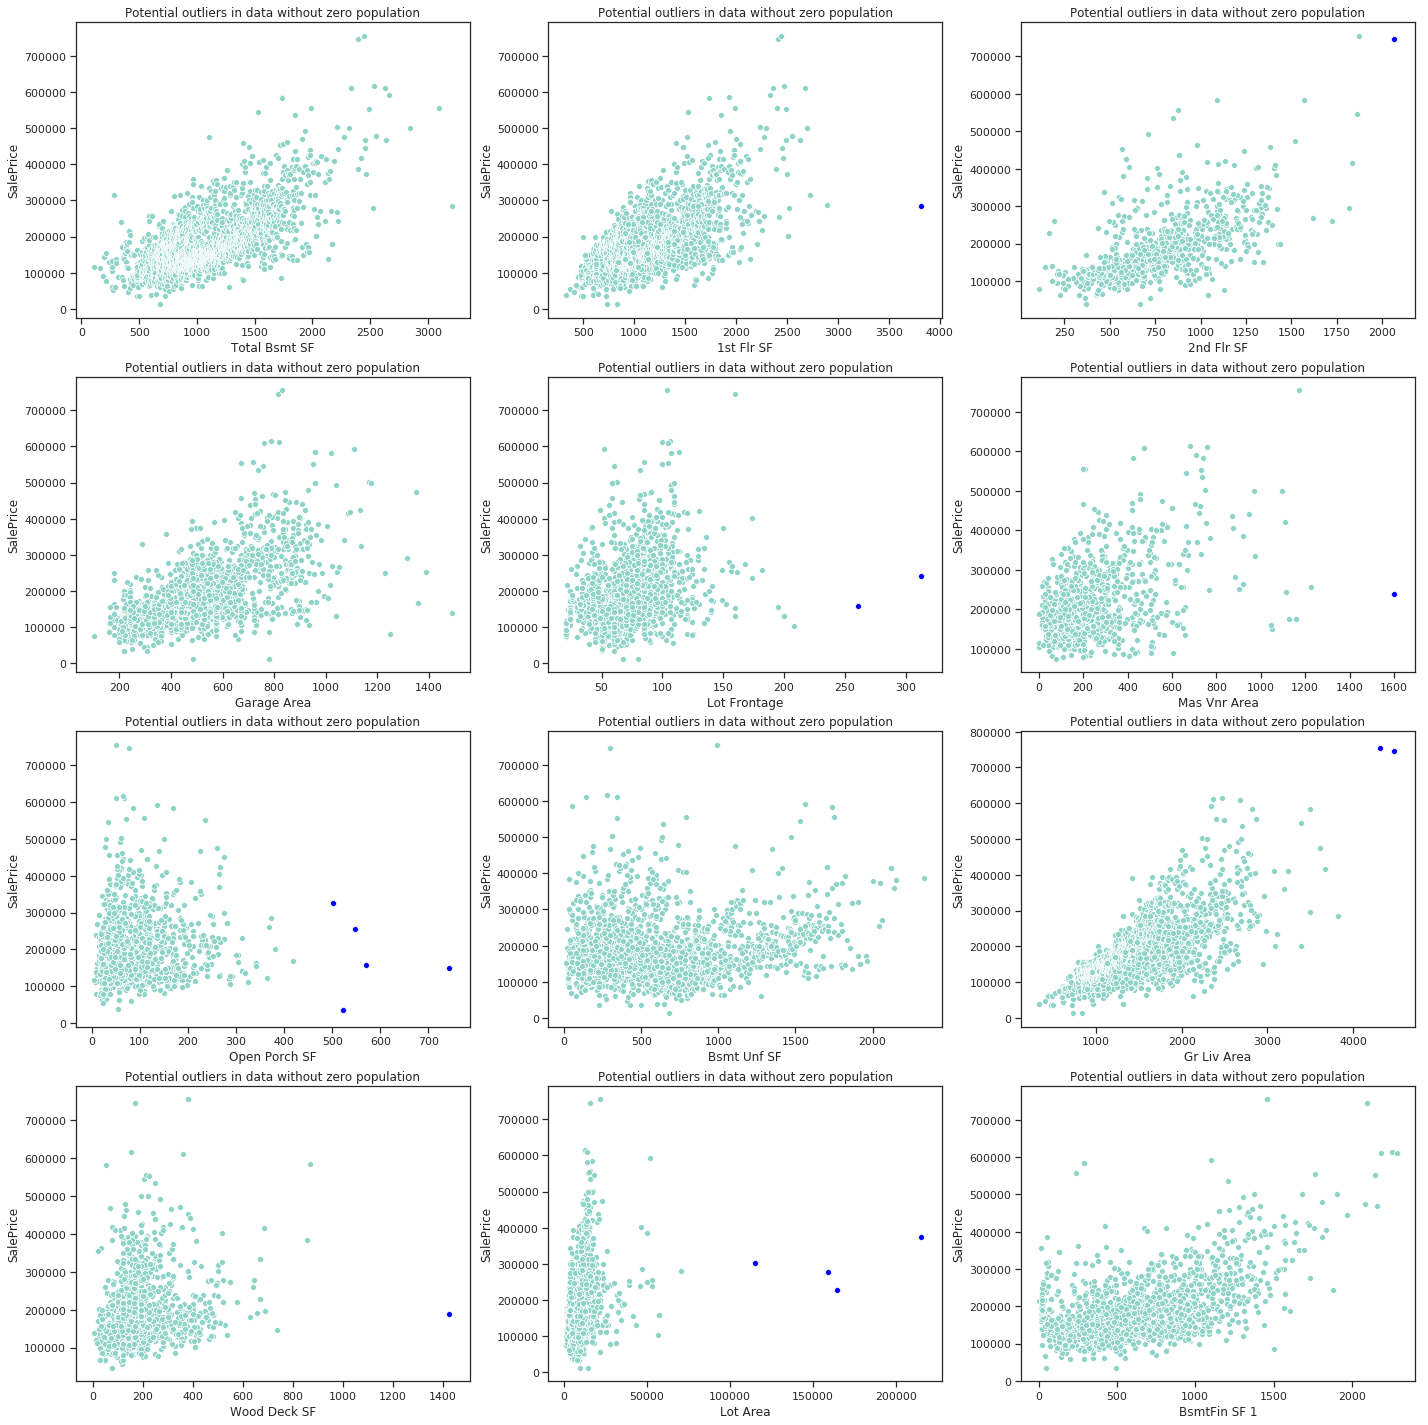

In [18]:
# Modifications asked after submitting

# Define a function that returns outliers, using IQR method.
def outliers_iqr( serie, coeff):
    quartile_1, quartile_3 = np.percentile( serie, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * coeff)
    upper_bound = quartile_3 + (iqr * coeff)

    return serie[ ( serie > upper_bound) | (serie < lower_bound) ].index


def remove_outliers( data, continuous_columns, dataWithSalePrice):
    if dataWithSalePrice:
        # display plots
        f, axes = plt.subplots(4, 3, figsize=(24, 25), sharey=False)

    # a variable to store all outliers indexes
    all_outliers_idx = []

    #column = 'Wood Deck SF'
    for idx, column in enumerate( continuous_columns):
        # Set the IQR coefficient depending on feature

        if np.isin( column, ['Garage Area', 'Open Porch SF','Total Bsmt SF']):
            coeff = 4.5
        elif np.isin( column, ['Mas Vnr Area' ]):
            coeff = 5
        elif np.isin( column, ['Wood Deck SF','Lot Frontage']):
            coeff = 6
        elif np.isin( column, ['Lot Area']):
            coeff = 15
        else:
            coeff = 3.5

        # Separate data into two sub-population with and without zero. Then I detect potential outliers for non zero population.

        # data without zero population
        data_nonZero = data.loc[ data[ column] != 0]
        outlier_nz_idx = outliers_iqr( data_nonZero[ column], coeff)
        data_nz_outliers = data_nonZero.loc[ outlier_nz_idx]
        print( '{} \toutliers in\t{}  \twithout zero values. IQR coeff = {}'. format( data_nz_outliers.shape[0], column, coeff) )

        # store outliers index for all features
        all_outliers_idx.extend( outlier_nz_idx) 

        if dataWithSalePrice:
            # data with zero population
            #outlier_idx = outliers_iqr( data[ column])
            #data_outliers = data.loc[ outlier_idx]
            #print( '{} outliers in {} with zero values.'. format( data_outliers.shape[0], column) )

            #f, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)

            #print data without zero and potential outliers
            ax = sns.scatterplot(x=data_nonZero[ column], y=data_nonZero['SalePrice'], ax=axes[ (idx // 3), (idx % 3)])
            sns.scatterplot(x=data_nz_outliers[ column], y=data_nz_outliers['SalePrice'], ax=axes[ (idx // 3), (idx % 3)], color='blue')
            ax.set_title('Potential outliers in data without zero population')

            #print data with zero and potential outliers
            #ax = sns.scatterplot(x=data[ column], y=data['SalePrice'], ax=axes[ 1])
            #sns.scatterplot(x=data_outliers[ column], y=data_outliers['SalePrice'], ax=axes[ 1], color='blue')
            #ax.set_title('Potential outliers in data with zero population')
            #f.suptitle( 'Example of potential outliers',  fontsize=16)

    plt.show()

    # Remove all outliers from data
    data.drop( all_outliers_idx, inplace = True )

remove_outliers( data, continuous_columns, True)

In [19]:
print('Data shape: {}'.format( data.shape) ) 
print('Data NaN count = {}\n'.format( data.isnull().sum().sum() ) )

Data shape: (2411, 51)
Data NaN count = 0



# Feature Engineering

## Log Transform for continuous and target features

I decide to apply log transformation on all contimuous features, because they have either a right skewed distribution or a right long tail. I display distribution before and after log transformation. so I see that distribution are not skewed afterwards.

Some features have many zero values, and their distribution after log transformation has two modes (peaks), one of which at 1. This is not a trouble for the model.

I see that after log transformation, all continuous features range from 1 to 12, so it is a tightened range and I don't need to scale these features.

I display distribution of values for continuous features. In green the original distribution, in blue the log distribution.


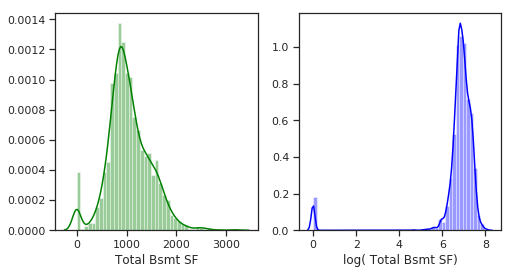

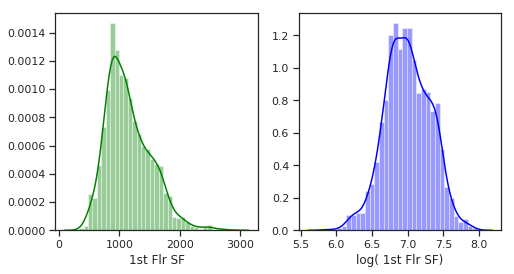

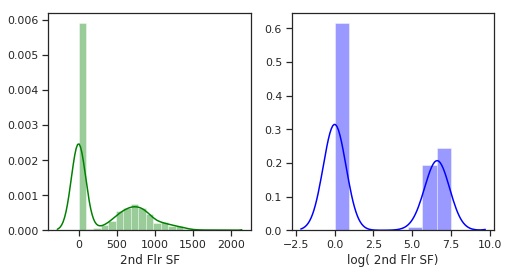

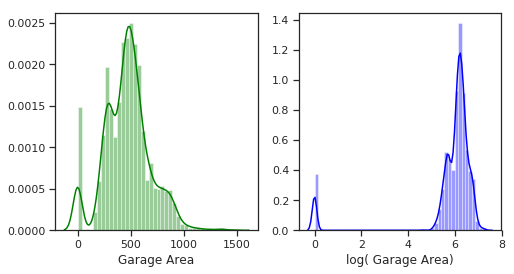

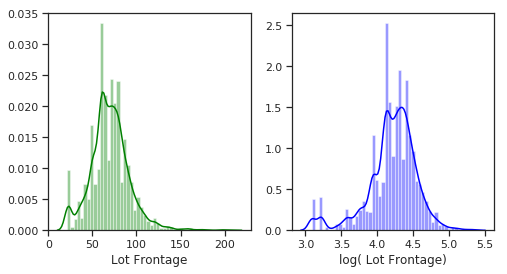

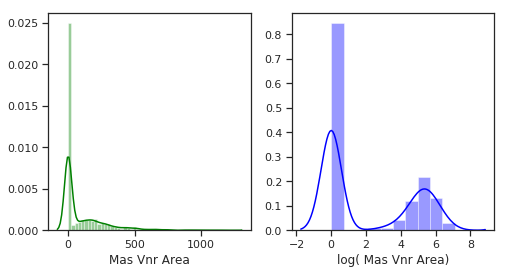

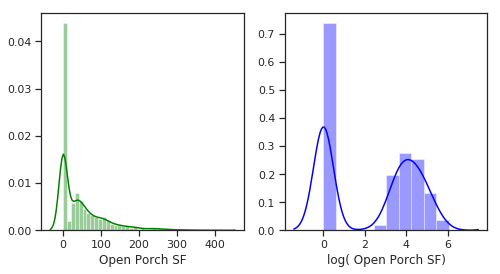

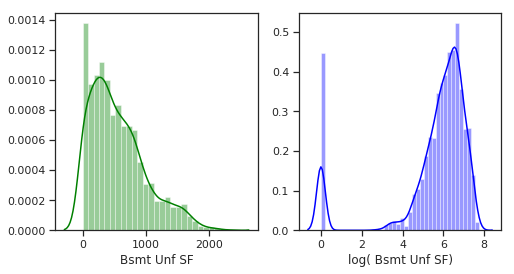

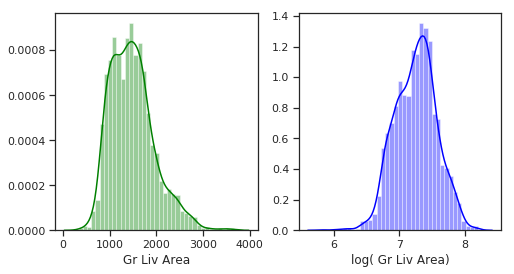

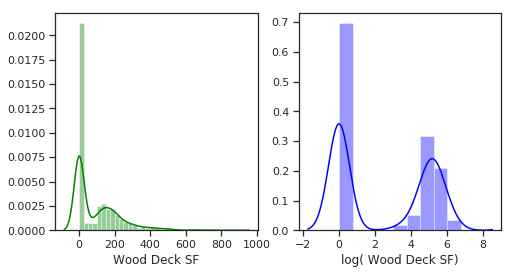

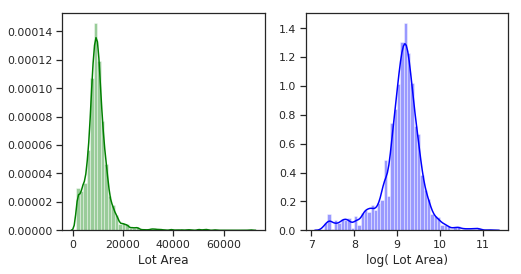

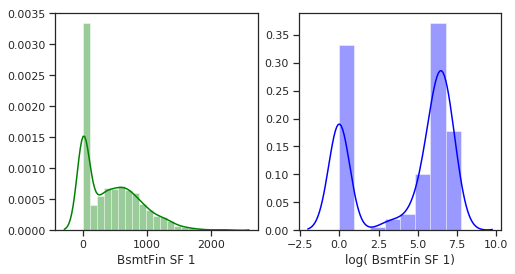

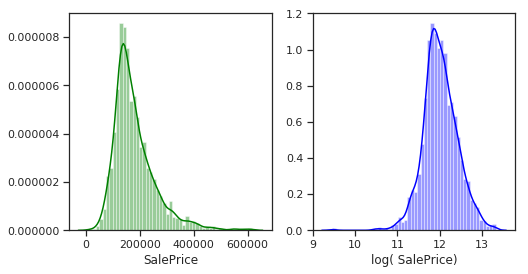

In [20]:
# set columns list
logTransform_columns = continuous_columns + ['SalePrice']

print('I display distribution of values for continuous features. In green the original distribution, in blue the log distribution.')
# show distribution plot for continuous and target features
for idx, col in enumerate( logTransform_columns): 
    f, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
    ax = sns.distplot( data[ col], ax=axes[ 0], color='green')
    ax.set_xlabel( col)
    ax = sns.distplot( np.log1p( data[ col]), ax=axes[ 1], color='blue')
    ax.set_xlabel( 'log( {})'.format( col) )

# Modifications asked after submitting

# I decide to apply log transformation on all contimuous features, because they have either a right skewed distribution or a right long tail.
scaler = StandardScaler()

def logTransformation_andStandardScaling( data, logTransform_columns):
    for col in logTransform_columns:
        data[ col] = np.log1p( data[ col])
        
        # I apply Standard scaling on all continuous features, except the target feature SalePrice.
        if col != 'SalePrice':
            col_2D = np.array( data[ col]).reshape(-1, 1)
            data[ col] = scaler.fit_transform( col_2D)
        
logTransformation_andStandardScaling( data, logTransform_columns)

## New indicators for Year features

I create new indicators for each feature with year values. I spread years into five periods.

In [21]:
# get min and max year
minYear = data['Year Built'].min()
maxYear = data['Year Built'].max()

# create bins
bins = [ minYear, pd.Timestamp(1940,1,1), pd.Timestamp(1960,1,1), pd.Timestamp(1980,1,1), pd.Timestamp(1990,1,1), maxYear]
columns_droped_year = ['Year Built', 'Garage Yr Blt', 'Year Remod/Add']

def new_indicator( data, bins, columns_droped_year):
    # I separate years into five periods.
    group_names = ['1875_40', '40_60', '60_80', '80_90', '90_2010']

    # I create a new indicators with the years periods for 'Year Built', 'Garage Yr Blt' and 'Year Remod/Add'
    data['yearBuilt_cat'] = pd.cut( data['Year Built'], bins, labels=group_names)
    data['garageYrBuilt_cat'] = pd.cut( data['Garage Yr Blt'], bins, labels=group_names)
    data['yearRemod_cat'] = pd.cut( data['Year Remod/Add'], bins, labels=group_names)
  
    # I drop Year features
    data.drop( columns_droped_year, axis=1, inplace=True)

new_indicator( data, bins, columns_droped_year)
print( color.PURPLE + 'I decide to drop columns and to replace them by a new feature:\n'+ color.END + '{}'.format( columns_droped_year))

# Remove droped columns from columns list
discrete_columns = list( set(discrete_columns).difference( set(columns_droped_year) ))

I decide to drop columns and to replace them by a new feature:
['Year Built', 'Garage Yr Blt', 'Year Remod/Add']


# Feature Encoding

I encode categorical features as follow:
- ordered categorical features with integer encoding.
- non ordered categorical featurs with One hot encoding
- two features 'Overall Qual' and 'Overall Cond' are already ordered with number, I don't modify them.

## Integer encoding

- 'Lot Shape' is documented as ordinal, but I don't think that the shape of the property has an order, i.e. a regular shape is not better than an irregulat one. So I will use One hot encoding for this feature.

- 'Land slope' is documented as ordinal, and I agree that a gentle slope is better than a severe one. I use integer encoding for this feature.



In [22]:
integer_encoding_columns = ['Exter Qual', 'Kitchen Qual', 'Bsmt Qual', 'Land Slope', 'Heating QC', 'Garage Finish', 'BsmtFin Type 1', 'Bsmt Exposure']

# create dictionary of ordinal to integer mapping for quality features
qual_dict = {'NA':1,
        'Po':2, 
        'Fa':3, 
        'TA':4, 
        'Gd':5, 
        'Ex':6}
 
# dictionary for finished feature
finished_dict = {'NA':1,
        'Unf':2, 
        'LwQ':3, 
        'Rec':4, 
        'BLQ':5, 
        'ALQ':6,
        'GLQ':7}
   
# dictionary for exposure feature
exposure_dict = {'NA':1,
        'No':2, 
        'Mn':3, 
        'Av':4, 
        'Gd':5}

# dictionary for garage feature
garage_dict = {'NA':1,
        'Unf':2, 
        'RFn':3, 
        'Fin':4}

# dictionary for slope feature
slope_dict = {'Sev':1,
        'Mod':2, 
        'Gtl':3}

# do the integer encoding
def integer_encoding( data):
    
    # quality features
    quality_col = ['Exter Qual', 'Kitchen Qual', 'Bsmt Qual', 'Heating QC']

    # apply dictionary on all quality features
    for col in quality_col:
        data[ col] = data[ col].map( qual_dict)
           
    # integer encoding for basement finished feature
    data['BsmtFin Type 1'] = data['BsmtFin Type 1'].map( finished_dict)
    
    # integer encoding for exposure feature
    data['Bsmt Exposure'] = data['Bsmt Exposure'].map( exposure_dict)
    
    # integer encoding for garage feature
    data['Garage Finish'] = data['Garage Finish'].map( garage_dict)
    
    # integer encoding for slope feature
    data['Land Slope'] = data['Land Slope'].map( slope_dict)
    
    return data

data = integer_encoding( data)

## One Hot encoding

I use One hot encoding for categorical features that are not ordered: 

I use One hot encoding for some discrete features that uses year or month categories: 'Mo Sold', 'Yr Sold', 'yearBuilt_categories', 'garageYyBuilt_categories', 'yearRemod_categories'

In [23]:
# set the list of columns that will be One Hot encoded
categorical_columns_onehot = ['Mo Sold', 'Yr Sold', 'yearBuilt_cat', 'garageYrBuilt_cat', 'yearRemod_cat']

oneHot_encoding_columns = categorical_columns + categorical_columns_onehot

# remove features that have been integer encoded
col_to_remove = integer_encoding_columns + ['Overall Qual', 'Overall Cond']
oneHot_encoding_columns = [ e for e in oneHot_encoding_columns if e not in col_to_remove]

# do the one hot encoding
def oneHot_encoding( data, oneHot_encoding_columns):
    data = pd.get_dummies(data, drop_first = True, columns= oneHot_encoding_columns )
    return data

data = oneHot_encoding( data, oneHot_encoding_columns)
    
print( 'the new data shape is {}'.format( data.shape ) )


the new data shape is (2411, 189)


## Features selection

I display a correlation matrix of all features versus the target feature SalePrice.
The correlation matrix shows:
- positively high correlation coefficients above 0.6, for 'Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Garage Cars'...
- positively moderate correlation coefficient between 0.4 and 0.6
- low correlation coefficient between -0.4 and 0.4
- negatively moderate correlation coefficient between -0.5 and -0.4

**Result:**

For the **simple model**, I select the two most correlated features: 
- 'Overall Qual'. It has ten categories and each category has a sale price range different from all other categories, so it is differentiating.
- 'Gr Liv Area'. The plot of 'Gr Liv Area' shows that sale price increase continuously with this factor.



For the **intermediate model**, I select the 15 most correlated features:  
- 'Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Garage Cars', 'Kitchen Qual', 'Bsmt Qual', '1st Flr SF','yearBuilt_cat_90_2010', 'Garage Finish', 'garageYrBuilt_cat_90_2010', 'Full Bath', 'Foundation_PConc', 'Fireplaces','yearRemod_cat_90_2010','Heating QC','TotRms AbvGrd','Open Porch SF'
- These features are:
    - either a categorical or discrete feature that differentiate the sale price, i.e. each category has a sale price range different from all other categories.
    - or a continuous feature that has a fair correlation with sale price, i.e. the sale price increases with this feature.

In [24]:
focus_cols = ['SalePrice']
corr = data.corr(method = 'pearson').filter(focus_cols).drop(focus_cols).sort_values(by=['SalePrice'],ascending=False)
corr.style.background_gradient(cmap='coolwarm')


,SalePrice
Overall Qual,0.830584
Gr Liv Area,0.721627
Exter Qual,0.68742
Garage Cars,0.6721
Kitchen Qual,0.664883
Bsmt Qual,0.641052
1st Flr SF,0.619522
yearBuilt_cat_90_2010,0.610553
Garage Finish,0.594218
garageYrBuilt_cat_90_2010,0.582124


# Model Fitting

## Simple Model
I choose to assign 20% of data to test data, because I want to use the maximun data to train the model. 20% is a minimum for test set.

I scale the continuous features because regresion model is sensitive to features wih different scales.

I choose a linear regression estimator, because I considered that there is no outliers, so I do not need a Huber loss estimator. The training data set has 2427 rows and 219 columns, so it is not a big one. Same for the test dataset, which has 500 rows and 218 columns, so I do not need a SGD algorithm.

**Results:**

The simple model has a R square = 0.74, that is a fair predctability. It means that 74% of the features explain the sale price.

MAE is 25 635 dollars, it means that the mean error for sale price predictions is 25 635 dollars. For example the first house (the first row) of the data set has a predicted sale price of 208 430 dollars and its observed sale price is 176 500 dollars. The difference is 31 930 dollars, it is above the mean error of 25 635.

The simple model MAE is better than the baseline MAE of 56 690 dollars, so the model worths it.

In [25]:
# a function that computes MAE
def MAE( y_ref, y_pred):
    return np.mean( np.absolute(y_ref - y_pred))

# set features list for simple model
data_simpleModel = data[ ['Overall Qual', 'Gr Liv Area','SalePrice'] ]

X = data_simpleModel.drop( ['SalePrice'], axis=1).values
y = data_simpleModel['SalePrice'].values

# Create the train and test data. 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=5)

#Fit a linear regression model
simpleModel = LinearRegression().fit( X_train, y_train)

#Predict test values
y_pred = simpleModel.predict( X_test )

# compute MAE for model and baseline
# I transform pedicion with np.exp( y ) -1, because they have been transform with np.log1p( y) during feature engineering
mae_simpleModel = MAE( np.exp(y_test) -1, np.exp(y_pred))
mae_baseline = MAE( np.exp(y_test) -1, np.exp(np.median( y_train)) )

#compute r2 score of the model
r2 = r2_score(y_test, y_pred)
title = 'MAE simple Model= {:.0f}, R2= {:.2f}\nMAE baseline= {:.0f}'.format( mae_simpleModel, r2, mae_baseline)
print( title)

MAE simple Model= 27287, R2= 0.75
MAE baseline= 59745


## Intermediate model

I use the same linear estimator as in the simple model, for the same reason. 

The intermediate model uses 15 features: 'Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Garage Cars', 'Kitchen Qual', 'Bsmt Qual', '1st Flr SF','yearBuilt_cat_90_2010', 'Garage Finish', 'garageYrBuilt_cat_90_2010', 'Full Bath','Foundation_PConc', 'Fireplaces','yearRemod_cat_90_2010','Heating QC', 'TotRms AbvGrd','Open Porch SF'


**Results:**

The intermediate model has a R square = 0.84, so it has a better predictability than the simple model.

MAE is 19 299 dollars, it is less than the simple model. 

So the intermediate model is better than the simple model.

In [26]:
columnName_intermediateModel = ['Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Garage Cars', 'Kitchen Qual', 'Bsmt Qual', '1st Flr SF','yearBuilt_cat_90_2010', \
                                'Garage Finish', 'garageYrBuilt_cat_90_2010', 'Full Bath', 'Foundation_PConc', 'Fireplaces','yearRemod_cat_90_2010','Heating QC',\
                                'TotRms AbvGrd','Open Porch SF','SalePrice']
  
# get data for intermediate model
data_intermediateModel = data[ columnName_intermediateModel ]

X = data_intermediateModel.drop( ['SalePrice'], axis=1).values
y = data_intermediateModel['SalePrice'].values

# Create the train and test data. 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=5)

#Fit a linear regression model
intermediateModel = LinearRegression().fit( X_train, y_train)

#Predict test values
y_pred = intermediateModel.predict( X_test )

#compute MAE for model and baseline
mae_IntermediateModel = MAE( np.exp(y_test), np.exp(y_pred))
mae_baseline = MAE( np.exp(y_test), np.exp(np.median( y_train)) )

#compute r2 score of the model
r2 = r2_score(y_test, y_pred)
title = 'MAE Intermediate Model={:.0f}, R2={:.2f}\nMAE baseline={:.0f}'.format( mae_IntermediateModel, r2, mae_baseline)
print( title)

MAE Intermediate Model=18970, R2=0.85
MAE baseline=59745


## Complex model

I use all features with this model.

I first used a linear regression model without regularization, but it results in a MAE = np.inf (infinity) and a negative R square. It means that the coefficients of the model are too big and I need to regularize them. 

So I use a Ridge model (linera regression with regularization). Ridge takes an input parameter alpha, that is not computed by the model, so I use a grid search to find it. I display the RSS (Root Sum Square) error indicator of the model versus alpha, and I see that the error starts to rise around 10. So from alpha = 10, the model starts underfitting.

I choose alpha = 10 to fit the model.


**Result:**

R square = 0.90, so predictability is better than the intermediate model.

MAE = 13 883 dollars, so the mean error is better than the intermediate model. With a median sale price for test data of 160 000 dollars, the mean error represents 8,6% of this median price.

The complex model is the best model of my three models. 


When I choose alpha = 0,01, then R square = 0.91 and MAE = 13  466 dollars. It is a little bit better than with alpha = 10.

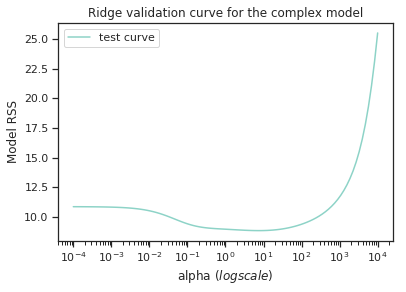

In [27]:
# A function that computes RSS
def RSS(y, y_pred):
     return np.sum(np.square( (y - y_pred) ))
    
gs_results = []

data_complexModel =  data

X = data_complexModel.drop( ['SalePrice'], axis=1).values
y = data_complexModel['SalePrice'].values

# Create the train and test data. 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=5)

#Grid search
for alpha in np.logspace(-4,4,num=100):   
    #Ridge regression
    complexModel = Ridge( alpha= alpha)
    
    #fit model
    complexModel.fit( X_train, y_train)

    #predict test values
    y_pred = complexModel.predict( X_test)

    #store results
    gs_results.append({
        'alpha': alpha,
        'rss_model': RSS(y_test, y_pred),
    })

#transform results
gs_results = pd.DataFrame(gs_results)

#plot the validation curve
plt.semilogx(gs_results['alpha'], gs_results['rss_model'], label='test curve')
plt.xlabel('alpha ($log scale)$')
plt.ylabel('Model RSS')
plt.legend()
plt.title('Ridge validation curve for the complex model')
plt.show()

In [28]:
# Modification done after submitting: complexModel = Ridge( alpha=10)
    
#Ridge regression with alpha = 10
complexModel = Ridge( alpha= 10)

#fit model
complexModel.fit( X_train, y_train)

#predict test values
y_pred = complexModel.predict( X_test)

#compute MAE for model and baseline
mae_complexModel = MAE( np.exp(y_test), np.exp(y_pred))
mae_baseline = MAE( np.exp(y_test), np.exp(np.median( y_train)) )

#compute r2 score of the model
r2 = r2_score(y_test, y_pred)
title = 'MAE complex Model={:.0f}, R2={:.2f}\nMAE baseline={:.0f}'.format( mae_complexModel, r2, mae_baseline)
print( title)

MAE complex Model=14363, R2=0.90
MAE baseline=59745


## Communicating results

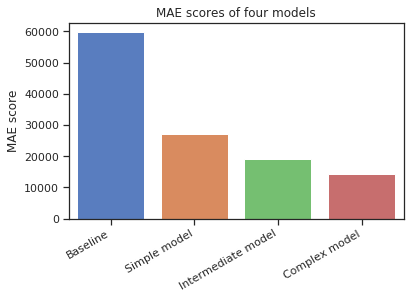

In [29]:
mae_df = pd.DataFrame({'regression': ['Baseline', 'Simple model', 'Intermediate model','Complex model'], 
                       'mae': [ mae_baseline, mae_simpleModel, mae_IntermediateModel, mae_complexModel]})

ax = sns.barplot(y = 'mae', x = 'regression', data = mae_df, palette="muted")
ax.set( xlabel= '', ylabel='MAE score', title='MAE scores of four models')

#label do not overlap
ax.figure.autofmt_xdate()
plt.show()

## Compute prediction

I check that there is no missing values in the test data.

I create a preprocess function for:
- cleaning ( replace NaN, drop unusefull feature, convert data type), 
- feature engineering (log transformation, new indicators) 
- and feature encoding (One hot encoding) the test data. 

It does not remove outliers, nor duplicates in test data.

It uses the same functions as for preprocessing the training data

Test data do not have the same features as the training data.
- There is on additional feature: 'Exterior 2nd_Other'. I remove it from test data.
- There are several missing features: 'Neighborhood_Greens', 'Exterior 2nd_AsphShn', 'Exterior 1st_AsphShn', 'Roof Style_Shed', 'Exterior 2nd_PreCast', 'Exterior 1st_CBlock', 'Neighborhood_Landmrk', 'Land Slope_Sev', 'Exterior 1st_Stone', 'Foundation_Wood', 'MS Zoning_C (all)', 'Exterior 1st_BrkComm', 'Exterior 1st_PreCast', 'Kitchen Qual_Po', 'Overall Cond_2', 'Exterior 1st_ImStucc', 'Neighborhood_GrnHill', 'MS Zoning_I (all)', 'Mas Vnr Type_CBlock', 'MS SubClass_150'.
I add them to test data and fill them with zero value.


**Results:**

Sale price prediction for:
- the simple range from 51 348 to 580 361 dollars
- the intermediate model range from 55 876 to 550 496 dollars
- the complex model range from 93 784 to 340 400 dollars

The range of the complex model is much more tightened.

The sale price distribution is skewed on the right, which is expected.

In [30]:
#Read data
data_test = pd.read_csv( 'house-prices-test.csv')
print('Original data test shape = {}'.format( data_test.shape))

Original data test shape = (500, 81)


In [31]:
# Check if there are missing values in the data set
nan_count = data_test.isnull().sum().sum()
print('NaN values in the test data: {}'.format( nan_count))

NaN values in the test data: 2327


In [32]:
# sort index in ascending order, in order to have PID feature sorted according to their index
data_test.sort_index()

# store the PID colunm
pid_column = data_test['PID']

# The preprocess function does data cleaning, feature engineering and feature encoding. I uses the same functions as for preprocessing the training data.
def preprocess_data( data, columns_droped_nan, bins, oneHot_encoding_columns):
    # data cleaning
    drop_col_notUsefull( data)
    convert_dateTime_col( data)
    drop_tooManyMissingValues_col( data, columns_droped_nan)
    replace_nan( data)
    replace_nan_lotArea( data)
    replace_nan_garage( data)
    replace_nan_electrical( data)
    drop_oneSingleValue_col( data)
    drop_manyZero( data)
    
    # feature engineering
    # Remove SalePrice feature because it is not in the test data
    logTransform_columns.remove( 'SalePrice' )
    logTransformation_andStandardScaling( data, logTransform_columns)
    
    new_indicator( data, bins, columns_droped_year)
    
    # feature encoding
    data = oneHot_encoding( data, oneHot_encoding_columns)
    data = integer_encoding( data)
    return data

data_test = preprocess_data( data_test,  columns_droped_nan, bins, oneHot_encoding_columns)   
print('data test shape after preprocessing = {}'.format( data_test.shape))

data test shape after preprocessing = (500, 172)


In [33]:
# get all columns in the reference dataframe used to fit the model
columns_in_reference = set( data.columns.values)
columns_in_test = set( data_test.columns.values)

# get columns that are in reference dataframe but not in test dataframe
columns_missing_in_test = list( columns_in_reference.difference( columns_in_test) )

# get columns that are in test dataframe but not in reference dataframe
columns_not_in_reference = list( columns_in_test.difference( columns_in_reference) )

# I drop columns in test dataframe that are not in the reference dataframe
data_test.drop( columns_not_in_reference, axis=1, inplace=True)

print('Here is the list of columns missing in data_test: {}'.format( columns_missing_in_test))

Here is the list of columns missing in data_test: ['MS Zoning_C (all)', 'MS Zoning_I (all)', 'Neighborhood_GrnHill', 'Exterior 2nd_AsphShn', 'Exterior 1st_BrkComm', 'Neighborhood_Landmrk', 'Foundation_Wood', 'MS SubClass_150', 'Exterior 2nd_PreCast', 'Exterior 1st_CBlock', 'Roof Style_Shed', 'Exterior 1st_AsphShn', 'Mas Vnr Type_CBlock', 'Exterior 1st_PreCast', 'SalePrice', 'Exterior 1st_ImStucc', 'Neighborhood_Greens', 'Exterior 1st_Stone']


In [34]:
# remove SalePrice from the list of columns
columns_for_reindex = data.columns.values.tolist()
columns_for_reindex.remove( 'SalePrice')

# Add missing columns to data_test and fill them with 0.
data_test = data_test.reindex( columns= columns_for_reindex, fill_value=0 )
data_test.shape

(500, 188)

In [35]:
# sort index in ascending order,  in order to have Sale price predictions sorted according to their index, as it has been done for PID feature.
data_test = data_test.sort_index()

### Prediction with the simple model

In [36]:
# select features for simple model
dataTest_simpleModel = data_test[ ['Overall Qual', 'Gr Liv Area'] ]

# make prediction for data_test
y_pred = simpleModel.predict( dataTest_simpleModel )

# Transform Sale price with np.exp() -1, because it has been previously transformed with np.log1p()
# convert number into int in order to remove decimal
y_pred = pd.Series( np.exp(y_pred) -1, name='SalePrice').astype( int)

# concatenate PID and Sale Price columns
df_simpleModel = pd.concat( (pid_column, y_pred), axis=1)

# save prediction in file
df_simpleModel.to_csv(r'predictions-simple-model.csv', index=False)

### Prediction with the intermediate model

In [37]:
# remove SalePrice from intermediate model columns list
columnName_intermediateModel.remove( 'SalePrice')   
    
# select features for intermediate model
dataTest_intermediateModel = data_test[ columnName_intermediateModel ]

# make prediction for data_test
y_pred = intermediateModel.predict( dataTest_intermediateModel )

# Transform Sale price with np.exp() -1, because it has been previously transformed with np.log1p()
# convert number into int in order to remove decimal
y_pred = pd.Series( np.exp(y_pred) -1, name='SalePrice').astype( int)

# concatenate PID and Sale Price columns
df_intermediateModel = pd.concat( (pid_column, y_pred), axis=1)

# save prediction in file
df_intermediateModel.to_csv(r'predictions-intermediate-model.csv', index=False)

### Prediction with the complex model

In [38]:
# select features for complex model
dataTest_complexModel = data_test

# make prediction for data_test
y_pred = complexModel.predict( dataTest_complexModel )

# Transform Sale price with np.exp() -1, because it has been previously transformed with np.log1p()
# convert number into int in order to remove decimal
y_pred = pd.Series( np.exp(y_pred) -1, name='SalePrice').astype( int)

# concatenate PID and Sale Price columns
df_complexModel = pd.concat( (pid_column, y_pred), axis=1)

# save prediction in file
df_complexModel.to_csv(r'predictions-complex-model.csv', index=False)

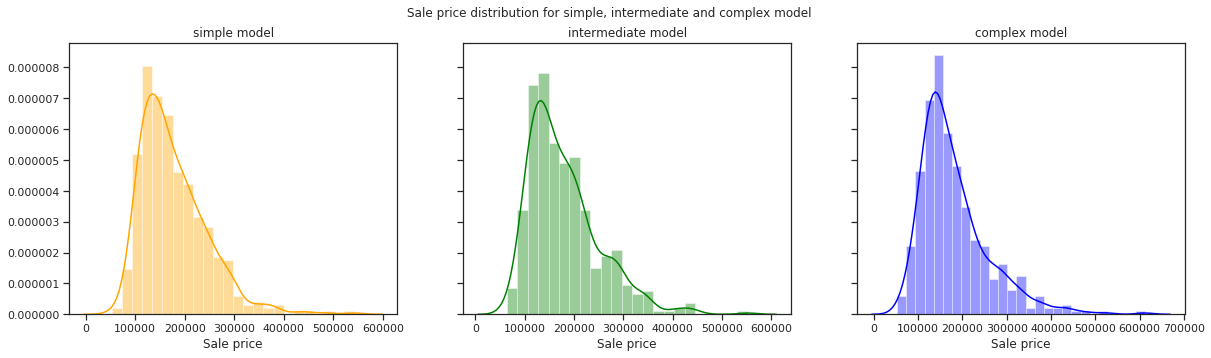

In [39]:
# Communicating the results
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
f.suptitle('Sale price distribution for simple, intermediate and complex model')
ax = sns.distplot( df_simpleModel[ 'SalePrice'], ax=axes[ 0], color='orange')
ax.set_xlabel( 'Sale price')
ax.set_title('simple model')
ax = sns.distplot( df_intermediateModel[ 'SalePrice'], ax=axes[ 1], color='green')
ax.set_xlabel( 'Sale price')
ax.set_title('intermediate model')
ax = sns.distplot( df_complexModel[ 'SalePrice'], ax=axes[ 2], color='blue')
ax.set_xlabel( 'Sale price') 
ax.set_title('complex model')
plt.show()